## CSV to midi

### Setup

In [1]:
import pandas as pd
import numpy as np
import pretty_midi
# import fluidsynth
from IPython import display
import glob
import collections
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
filenames = glob.glob('../raw_data/mozart_sonatas/mps - K*')
print('Number of files:', len(filenames))
print('first file:', filenames[0])

Number of files: 57
first file: ../raw_data/mozart_sonatas/mps - K311-I.csv


**create pieces df (each row is one piece)**

In [3]:
pieces_df = pd.read_csv('../raw_data/mozart_sonatas/mps - pieces.csv')
pieces_df.head()

,name,key,title,time_sig,tempo marking,bpm,pickup_bar,pickup_length
0,K545-I,c major,NaN,common,allegro,4=132,0,0
1,K545-II,g major,NaN,3/4,andante,4=60,0,0
2,K545-III,c major,Rondo,2/4,allegretto grazioso,4=104,1,4
3,K283-I,g major,NaN,3/4,allegro,4=138,1,4
4,K283-II,c major,NaN,common,andante,4=58,0,0


### Normalize pitches to C major / A minor

**create key converter dictionaries**

In [4]:
all_keys = set([key for key in pieces_df.key.value_counts().index])
all_keys

{'a major',
 'a minor',
 'bb major',
 'c major',
 'c minor',
 'd major',
 'eb major',
 'f major',
 'f minor',
 'g major'}

In [5]:
# key: # of half steps to add to get to c major / a minor
maj_key_converter_dict = {'a major': 3, 'bb major': 2, 'c major': 0, 'd major': -2, 'eb major': -3, 'f major': -5, 'g major': 5}
min_key_converter_dict = {'a minor': 0, 'c minor': -3, 'f minor': 4}

In [6]:
def normalize_pitches(x, piece_key_type, piece_key):
    if x > 0:
        if piece_key_type == 'major':
            x += maj_key_converter_dict[piece_key]
        else:
            x += min_key_converter_dict[piece_key]
    return x

### Create duration (in seconds) column

In [7]:
bpm_beat_types = set([bpm.split('=')[0] for bpm in pieces_df.bpm.value_counts().index])
bpm_beat_types

{'2', '2d', '4', '4d', '8'}

In [8]:
# bpm note value: amount to multiply bpm by to convert bpm to quarter notes
bpm_converter_dict = {'2': 2, '2d': 3, '4': 1, '4d': 1.5, '8': 0.5}

In [9]:
# duration: amount to multiply spb (seconds per beat) by to get duration in seconds
beat_dict = {
    '1': 4, 
    '2': 2, 
    '4': 1, 
    '8': 0.5,
    '16': 0.25,
    '32': 0.125,
    '64': 0.0625
}

In [10]:
def duration_to_seconds(x, piece_spb):
    if type(x) != 'str':
        x = str(x)
    if x[-2:] == 'dd':
        s = piece_spb * beat_dict[x[:-2]] * 1.75
    elif x[-1] == 'd':
        s = piece_spb * beat_dict[x[:-1]] * 1.5
    else:
        s = piece_spb * beat_dict[x]
    return s

### preprocess all dfs

In [11]:
def process_df(filename):
    
    # extract the K number
    k_num = filename.split(' - ')[1].split('.csv')[0].strip(' ')
    
    # create df
    df = pd.read_csv(filename)  # make df
    
    # normalize pitch
    print(k_num)
    df['pitch'] = df.note_name.apply(lambda x: pretty_midi.note_name_to_number(x) if x != 'r' else 0)  
    piece_key = pieces_df[pieces_df['name'] == k_num]['key'].values[0].strip(' ')
    piece_key_type = piece_key.split(' ')[1].strip(' ')
    df['pitch_norm'] = df.pitch.apply(normalize_pitches, args=(piece_key_type, piece_key))
    
    # get duration in seconds
    piece_bpm = pieces_df[pieces_df['name'] == k_num]['bpm'].values[0].split('=')
    piece_bpm_norm = int(bpm_converter_dict[piece_bpm[0]] * int(piece_bpm[1]))
    piece_spb = 60 / piece_bpm_norm
    df['dur(s)'] = df.duration.apply(duration_to_seconds, args=(piece_spb,))
    
    return df

In [12]:
all_csv_dfs = []
for file in filenames:
    all_csv_dfs.append(process_df(file))

K311-I
K545-III
K310-III
K332-II
K309-III
K457-II
K284-III
K545-II
K457-III
K330-II
K333-I
K284-II
K331-I
K279-III
K311-III
K570-III
K310-II
K310-I
K309-I
K280-II
K498a-IV
K330-I
K545-I
K282-II
K332-I
K333-II
K576-I
K533-I
K570-II
K331-III
K309-II
K282-III
K282-I
K280-I
K498a-III
K547a-I
K570-I
K279-I
K284-I
K498a-II
K331-II
K330-III
K283-III
K281-II
K533-III
K311-II
K457-I
K281-III
K283-I
K576-II
K332-III
K533-II
K498a-I
K280-III
K576-III
K333-III
K283-II


In [13]:
all_csv_dfs[5].head()

,note_name,duration,measure,beat,subdiv,harm,from_root,NCT,BI2,CI,trill,dynamic,pitch,pitch_norm,dur(s)
0,bb4,4,1,1,1,I,5,0,0,0,0,p,70,67,2.00
1,g4,8,1,2,1,I,3,0,0,0,0,p,67,64,1.00
2,g4,8,1,2,3,I,3,0,0,0,0,p,67,64,1.00
3,g4,8dd,1,3,1,I64,3,0,0,0,0,p,67,64,1.75
4,ab4,32,1,3,4&,I64,4,1,0,0,0,p,68,65,0.25


### Create midi file

In [30]:
def notes_to_midi(
    notes: pd.DataFrame,
    instrument_name: str,
    velocity: int = 100 # note loudness
) -> pretty_midi.PrettyMIDI:
    
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))
    
    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start)
        end = float(prev_start + note['dur(s)'])
        if note['note_name'] == 'r':
            start += float(note['dur(s)'])
            prev_start = start
        else:
            note = pretty_midi.Note(
                velocity=velocity,
                pitch=note.pitch_norm,
#                 pitch=int(pretty_midi.note_name_to_number(note['note_name'])),
                start=start,
                end=end
            )
            instrument.notes.append(note)
            prev_start = end
            
    pm.instruments.append(instrument)
    return pm

In [31]:
instrument_name = 'Acoustic Guitar (nylon)'

all_midis = []
for df in all_csv_dfs:
    pm = notes_to_midi(df, instrument_name)
    all_midis.append(pm)

In [32]:
instrument = all_midis[0].instruments[0]
instrument.notes

[Note(start=0.000000, end=0.454545, pitch=72, velocity=100),
 Note(start=0.909091, end=1.022727, pitch=77, velocity=100),
 Note(start=1.022727, end=1.136364, pitch=76, velocity=100),
 Note(start=1.136364, end=1.250000, pitch=74, velocity=100),
 Note(start=1.250000, end=1.363636, pitch=76, velocity=100),
 Note(start=1.363636, end=1.477273, pitch=79, velocity=100),
 Note(start=1.477273, end=1.590909, pitch=77, velocity=100),
 Note(start=1.590909, end=1.704545, pitch=76, velocity=100),
 Note(start=1.704545, end=1.818182, pitch=77, velocity=100),
 Note(start=1.818182, end=2.272727, pitch=79, velocity=100),
 Note(start=2.727273, end=2.954545, pitch=79, velocity=100),
 Note(start=2.954545, end=3.181818, pitch=81, velocity=100),
 Note(start=3.181818, end=3.409091, pitch=83, velocity=100),
 Note(start=3.409091, end=3.636364, pitch=84, velocity=100),
 Note(start=3.636364, end=4.090909, pitch=79, velocity=100),
 Note(start=4.090909, end=4.545455, pitch=76, velocity=100),
 Note(start=4.545455, en

### Playback the midi

In [38]:
_SAMPLING_RATE = 16000

def display_audio(pm: pretty_midi.PrettyMIDI):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    return display.Audio(waveform, rate=_SAMPLING_RATE)

In [39]:
# instrument_name = 'Electric Piano 1'
instrument_name = 'Acoustic Guitar (nylon)'
out_file = 'example.midi'

example_pm = notes_to_midi(all_csv_dfs[10], instrument_name)

In [19]:
#display_audio(example_pm)

### Create dataframe from midi

In [45]:
filenames[45]

'../raw_data/mozart_sonatas/mps - K311-II.csv'

In [41]:
instrument = example_pm.instruments[0]
instrument.notes

[Note(start=0.000000, end=0.129310, pitch=81, velocity=100),
 Note(start=0.129310, end=0.258621, pitch=79, velocity=100),
 Note(start=0.258621, end=0.387931, pitch=77, velocity=100),
 Note(start=0.387931, end=0.517241, pitch=76, velocity=100),
 Note(start=0.517241, end=0.775862, pitch=74, velocity=100),
 Note(start=0.775862, end=1.034483, pitch=72, velocity=100),
 Note(start=1.034483, end=1.810345, pitch=72, velocity=100),
 Note(start=1.810345, end=2.068966, pitch=76, velocity=100),
 Note(start=2.068966, end=2.327586, pitch=81, velocity=100),
 Note(start=2.327586, end=2.586207, pitch=76, velocity=100),
 Note(start=2.586207, end=3.103448, pitch=79, velocity=100),
 Note(start=3.103448, end=3.879310, pitch=77, velocity=100),
 Note(start=3.879310, end=4.008621, pitch=79, velocity=100),
 Note(start=4.008621, end=4.137931, pitch=81, velocity=100),
 Note(start=4.137931, end=4.267241, pitch=79, velocity=100),
 Note(start=4.267241, end=4.396552, pitch=77, velocity=100),
 Note(start=4.396552, en

In [42]:
def midi_to_notes(midi: pretty_midi.PrettyMIDI()) -> pd.DataFrame:
#     pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = midi.instruments[0]
    notes = collections.defaultdict(list)
    
    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start
    
    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start-prev_start)
        notes['duration'].append(end - start)
        prev_start = start
        
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [43]:
all_midi_dfs = []

for midi in all_midis:
    midi_df = midi_to_notes(midi)
    all_midi_dfs.append(midi_df)

In [44]:
all_midi_dfs[45].head()

,pitch,start,end,step,duration
0,76,0.00000,0.62500,0.00000,0.62500
1,77,0.62500,1.09375,0.62500,0.46875
2,76,1.09375,1.25000,0.46875,0.15625
3,74,1.25000,1.87500,0.15625,0.62500
4,76,1.87500,2.50000,0.62500,0.62500


In [46]:
max_pitch_list = []
min_pitch_list = []
pitch_list = []
for midi in all_midi_dfs:
    max_pitch_list.append(midi.pitch.max())
    min_pitch_list.append(midi.pitch.min())
    for pitch in midi.pitch:
        if pitch not in pitch_list:
            pitch_list.append(pitch)

In [47]:
pitch_list.sort()
print(f"highest note: {max(max_pitch_list)} ({pretty_midi.note_number_to_name(max(max_pitch_list))})")
print(f"lowest note:, {min(min_pitch_list)} ({pretty_midi.note_number_to_name(min(min_pitch_list))})")
print('number of different notes:', len(pitch_list))

highest note: 87 (D#6)
lowest note:, 55 (G3)
number of different notes: 31


### Create slices

In [151]:
slice_length = 10
X = []
y = []

for midi in all_midi_dfs:
    df_len = len(midi)
    last_possible_index = df_len - (slice_length)
    for i in range(last_possible_index):
        X.append(midi.loc[i:i+slice_length - 1])
        y.append(midi.loc[i+slice_length])

In [59]:
# num_slices_per_midi = 5
# slice_length = 4
# X = []
# y = []

# for midi in all_midi_dfs:
#     df_len = len(midi)
#     last_possible_ind = df_len - (slice_length + 1)
#     slice_ind = np.random.choice(last_possible_ind, num_slices_per_midi, replace=False)
#     for i in slice_ind:
#         X.append(midi.loc[i:i+(slice_length - 1)])
#         y.append(midi.loc[i+slice_length])


In [152]:
X[0].values

array([[72.        ,  0.        ,  0.45454545,  0.        ,  0.45454545],
       [77.        ,  0.90909091,  1.02272727,  0.90909091,  0.11363636],
       [76.        ,  1.02272727,  1.13636364,  0.11363636,  0.11363636],
       [74.        ,  1.13636364,  1.25      ,  0.11363636,  0.11363636],
       [76.        ,  1.25      ,  1.36363636,  0.11363636,  0.11363636],
       [79.        ,  1.36363636,  1.47727273,  0.11363636,  0.11363636],
       [77.        ,  1.47727273,  1.59090909,  0.11363636,  0.11363636],
       [76.        ,  1.59090909,  1.70454545,  0.11363636,  0.11363636],
       [77.        ,  1.70454545,  1.81818182,  0.11363636,  0.11363636],
       [79.        ,  1.81818182,  2.27272727,  0.11363636,  0.45454545]])

**transpose notes to all 12 keys**

In [164]:
(X[0].values + np.array([[3, 0, 0, 0, 0]])).shape

(10, 5)

In [162]:
X[0].values.shape

(10, 5)

In [165]:
X_np = []

for seq in X:    
#     for i in range(1, 6):
#         transposer = np.array([[i, 0, 0, 0, 0]])
#         X_np.append(seq + transposer)
    for i in range(-6, 6):
        transposer = np.array([[i, 0, 0, 0, 0]])
        X_np.append(seq + transposer)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
print(len(X_np)
# print(len(X_trans_2) + len(X_trans_1))

**create 3d tensors for model**

In [116]:
X_seq = []
for slice in X:
    X_seq.append(np.delete(slice.values, [1,2], axis=1))

X_3d = np.stack(X_seq)

y_seq = []
for slice in y:
    y_seq.append(np.delete(slice.values, [1,2]))

y_2d = np.stack(y_seq)

In [117]:
print(X_3d.shape)
print(y_2d.shape)

(726, 10, 3)
(726, 3)


### Simple model

In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def initialize_model():
    model = Sequential()
    
    model.add(layers.LSTM(256, activation='tanh', input_shape=X_3d.shape[1:], return_sequences=True))
    
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.LSTM(32, activation='tanh'))
    model.add(layers.Dense(32, activation='relu'))
    
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(3, activation='linear'))
    
    model.compile(loss='mse', optimizer='rmsprop')
    
    return model

In [119]:
model = initialize_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 10, 256)           266240    
_________________________________________________________________
dropout_17 (Dropout)         (None, 10, 256)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 32)                36992     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 99        
Total params: 304,387
Trainable params: 304,387
Non-trainable params: 0
_______________________________________________

In [120]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

filepath = '../models.{epoch:02d}-{val_loss:.2f}.h5'

# Trains the model
es = [EarlyStopping(patience=10, restore_best_weights=True),
      ModelCheckpoint(filepath=filepath, save_best_only=True)]

model = initialize_model()
history = model.fit(X_3d, y_2d, validation_split=0.3, batch_size=16, epochs=500, verbose=1, callbacks=[es])

Epoch 1/500
32/32 [==============================] - 6s 66ms/step - loss: 1454.1735 - val_loss: 1279.1636
Epoch 2/500
32/32 [==============================] - 1s 37ms/step - loss: 1187.9385 - val_loss: 1053.9354
Epoch 3/500
32/32 [==============================] - 1s 39ms/step - loss: 959.4345 - val_loss: 824.8548
Epoch 4/500
32/32 [==============================] - 1s 34ms/step - loss: 732.0153 - val_loss: 598.6304
Epoch 5/500
32/32 [==============================] - 1s 36ms/step - loss: 520.8998 - val_loss: 391.1151
Epoch 6/500
32/32 [==============================] - 1s 36ms/step - loss: 324.5935 - val_loss: 219.1983
Epoch 7/500
32/32 [==============================] - 1s 38ms/step - loss: 182.6804 - val_loss: 91.7665
Epoch 8/500
32/32 [==============================] - 1s 30ms/step - loss: 85.7445 - val_loss: 30.3681
Epoch 9/500
32/32 [==============================] - 1s 37ms/step - loss: 57.4021 - val_loss: 13.8925
Epoch 10/500
32/32 [==============================] - 1s 31ms/ste

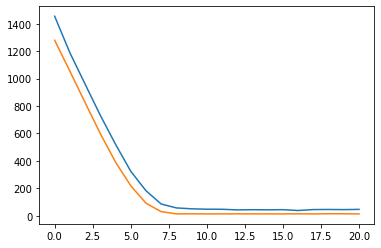

In [121]:
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])

In [122]:
X_test = tf.expand_dims(X_3d[0], 0)

y_pred = model.predict(X_test)

y_pred

array([[71.698586  ,  0.33204037,  0.34590912]], dtype=float32)

### Generate Notes

In [112]:
number_predictions = 20

input_notes = X_3d[0]

generated_notes = []
prev_start = 0
for i in range(number_predictions):
    inputs = tf.expand_dims(input_notes, 0)
    y_pred = model.predict(inputs)
    pitch = int(y_pred[0][0])
    step = y_pred[0][1]
    duration = y_pred[0][2]
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start
    

In [113]:
generated_notes = pd.DataFrame(generated_notes, columns=all_midi_dfs[0].columns)

generated_notes

,pitch,start,end,step,duration
0,75,0.406088,0.245127,0.406088,0.651214
1,75,0.408210,0.245432,0.814297,1.059730
2,74,0.411797,0.245947,1.226094,1.472041
3,74,0.415004,0.246402,1.641098,1.887500
4,74,0.416593,0.246623,2.057692,2.304315
5,73,0.417136,0.246697,2.474828,2.721525
6,73,0.419561,0.247043,2.894389,3.141431
7,73,0.421495,0.247317,3.315884,3.563201
8,73,0.422101,0.247401,3.737985,3.985386
9,73,0.422148,0.247406,4.160133,4.407538


### stack all dfs together

In [26]:
midi_dfs_stack = np.vstack(all_midi_dfs)

num_slices = 200
slice_length = 30
X = []
y = []

array_len = midi_dfs_stack.shape[0]
last_possible_ind = array_len - (slice_length + 1)
slice_ind = np.random.choice(last_possible_ind, num_slices, replace=False)   
    
for i in slice_ind:
    X.append(midi_dfs_stack[i:i+(slice_length - 1)])
    y.append(midi_dfs_stack[i+slice_length])

In [27]:
X[0]

array([[71.        ,  8.5       ,  9.        ,  1.        ,  0.5       ],
       [73.        ,  9.        , 10.        ,  0.5       ,  1.        ],
       [76.        , 10.        , 10.25      ,  1.        ,  0.25      ],
       [74.        , 10.25      , 10.5       ,  0.25      ,  0.25      ],
       [73.        , 10.5       , 11.5       ,  0.25      ,  1.        ],
       [71.        , 11.5       , 12.        ,  1.        ,  0.5       ],
       [67.        ,  0.        ,  0.5       ,  0.        ,  0.5       ],
       [72.        ,  0.5       ,  1.5       ,  0.5       ,  1.        ],
       [77.        ,  1.5       ,  2.5       ,  1.        ,  1.        ],
       [76.        ,  2.5       ,  2.625     ,  1.        ,  0.125     ],
       [79.        ,  2.625     ,  2.75      ,  0.125     ,  0.125     ],
       [77.        ,  2.75      ,  2.875     ,  0.125     ,  0.125     ],
       [76.        ,  2.875     ,  3.        ,  0.125     ,  0.125     ],
       [81.        ,  3.        ,  3.1

In [28]:
X_seq = []
for sequence in X:
    X_seq.append(np.delete(sequence, [1,2], axis=1))

X_3d = np.stack(X_seq)

y_seq = []
for sequence in y:
    y_seq.append(np.delete(sequence, [1,2]))

y_2d = np.stack(y_seq)

In [29]:
print(X_3d.shape)
print(y_2d.shape)

(200, 29, 3)
(200, 3)


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def initialize_model():
    model = Sequential()
    model.add(layers.LSTM(units=len(pitch_list), activation='tanh', kernel_regularizer='l1', input_shape=X_3d.shape[1:]))
    model.add(layers.Dense(3, activation='linear'))
    
    model.compile(loss='mse', optimizer='rmsprop')
    
    return model

In [56]:
model.save('model.h5')

In [57]:
from keras.models import load_model

In [58]:
model = load_model('model.h5')

In [40]:
model = initialize_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 31)                4340      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 96        
Total params: 4,436
Trainable params: 4,436
Non-trainable params: 0
_________________________________________________________________


In [42]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=20, restore_best_weights=True)

model = initialize_model()
history = model.fit(X_3d, y_2d, validation_split=0.3, batch_size=16, epochs=300, verbose=1, callbacks=[es])

2022-03-02 17:44:18.610617: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300
9/9 [==============================] - 3s 84ms/step - loss: 1776.7311 - val_loss: 1768.9154
Epoch 2/300
9/9 [==============================] - 0s 19ms/step - loss: 1762.6945 - val_loss: 1756.9510
Epoch 3/300
9/9 [==============================] - 0s 20ms/step - loss: 1750.7415 - val_loss: 1744.0638
Epoch 4/300
9/9 [==============================] - 0s 20ms/step - loss: 1736.0715 - val_loss: 1726.3396
Epoch 5/300
9/9 [==============================] - 0s 19ms/step - loss: 1714.9716 - val_loss: 1699.7561
Epoch 6/300
9/9 [==============================] - 0s 20ms/step - loss: 1685.5924 - val_loss: 1669.4896
Epoch 7/300
9/9 [==============================] - 0s 19ms/step - loss: 1656.2753 - val_loss: 1639.6112
Epoch 8/300
9/9 [==============================] - 0s 21ms/step - loss: 1623.9850 - val_loss: 1603.7882
Epoch 9/300
9/9 [==============================] - 0s 20ms/step - loss: 1585.3297 - val_loss: 1560.8412
Epoch 10/300
9/9 [==============================] - 0s 21ms/step

Epoch 80/300
9/9 [==============================] - 0s 18ms/step - loss: 673.0337 - val_loss: 667.9169
Epoch 81/300
9/9 [==============================] - 0s 18ms/step - loss: 664.5768 - val_loss: 659.4638
Epoch 82/300
9/9 [==============================] - 0s 19ms/step - loss: 656.1325 - val_loss: 651.0516
Epoch 83/300
9/9 [==============================] - 0s 19ms/step - loss: 647.7568 - val_loss: 642.6989
Epoch 84/300
9/9 [==============================] - 0s 18ms/step - loss: 639.4567 - val_loss: 634.4242
Epoch 85/300
9/9 [==============================] - 0s 18ms/step - loss: 631.1892 - val_loss: 626.1254
Epoch 86/300
9/9 [==============================] - 0s 18ms/step - loss: 622.9703 - val_loss: 617.9659
Epoch 87/300
9/9 [==============================] - 0s 18ms/step - loss: 614.8163 - val_loss: 609.8109
Epoch 88/300
9/9 [==============================] - 0s 18ms/step - loss: 606.7162 - val_loss: 601.7418
Epoch 89/300
9/9 [==============================] - 0s 18ms/step - loss: 

Epoch 159/300
9/9 [==============================] - 0s 18ms/step - loss: 171.8556 - val_loss: 168.1976
Epoch 160/300
9/9 [==============================] - 0s 18ms/step - loss: 167.7402 - val_loss: 164.1203
Epoch 161/300
9/9 [==============================] - 0s 18ms/step - loss: 163.6606 - val_loss: 160.0093
Epoch 162/300
9/9 [==============================] - 0s 18ms/step - loss: 159.5972 - val_loss: 155.9831
Epoch 163/300
9/9 [==============================] - 0s 18ms/step - loss: 155.5948 - val_loss: 151.9913
Epoch 164/300
9/9 [==============================] - 0s 20ms/step - loss: 151.6578 - val_loss: 148.0884
Epoch 165/300
9/9 [==============================] - 0s 18ms/step - loss: 147.7780 - val_loss: 144.2237
Epoch 166/300
9/9 [==============================] - 0s 18ms/step - loss: 143.9643 - val_loss: 140.4226
Epoch 167/300
9/9 [==============================] - 0s 18ms/step - loss: 140.2056 - val_loss: 136.6984
Epoch 168/300
9/9 [==============================] - 0s 18ms/ste

9/9 [==============================] - 0s 18ms/step - loss: 9.2906 - val_loss: 6.9975
Epoch 240/300
9/9 [==============================] - 0s 19ms/step - loss: 9.2340 - val_loss: 6.9436
Epoch 241/300
9/9 [==============================] - 0s 18ms/step - loss: 9.2010 - val_loss: 6.9271
Epoch 242/300
9/9 [==============================] - 0s 18ms/step - loss: 9.1750 - val_loss: 6.9024
Epoch 243/300
9/9 [==============================] - 0s 18ms/step - loss: 9.1704 - val_loss: 6.8758
Epoch 244/300
9/9 [==============================] - 0s 18ms/step - loss: 9.1359 - val_loss: 6.8684
Epoch 245/300
9/9 [==============================] - 0s 18ms/step - loss: 9.1385 - val_loss: 6.8547
Epoch 246/300
9/9 [==============================] - 0s 18ms/step - loss: 9.1329 - val_loss: 6.8455
Epoch 247/300
9/9 [==============================] - 0s 18ms/step - loss: 9.1187 - val_loss: 6.8374
Epoch 248/300
9/9 [==============================] - 0s 18ms/step - loss: 9.1124 - val_loss: 6.8381
Epoch 249/300


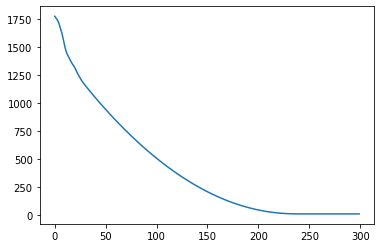

In [43]:
plt.plot(history.epoch, history.history['loss'])

In [54]:
number_predictions = 20

input_notes = X_3d[0]

In [55]:
X_3d[0]

array([[71.        ,  1.        ,  0.5       ],
       [73.        ,  0.5       ,  1.        ],
       [76.        ,  1.        ,  0.25      ],
       [74.        ,  0.25      ,  0.25      ],
       [73.        ,  0.25      ,  1.        ],
       [71.        ,  1.        ,  0.5       ],
       [67.        ,  0.        ,  0.5       ],
       [72.        ,  0.5       ,  1.        ],
       [77.        ,  1.        ,  1.        ],
       [76.        ,  1.        ,  0.125     ],
       [79.        ,  0.125     ,  0.125     ],
       [77.        ,  0.125     ,  0.125     ],
       [76.        ,  0.125     ,  0.125     ],
       [81.        ,  0.125     ,  0.125     ],
       [77.        ,  0.125     ,  0.125     ],
       [74.        ,  0.125     ,  0.125     ],
       [72.        ,  0.125     ,  0.125     ],
       [71.        ,  0.125     ,  0.125     ],
       [72.        ,  0.125     ,  0.125     ],
       [74.        ,  0.125     ,  0.125     ],
       [71.        ,  0.125     ,  0.125

In [52]:
generated_notes = []
prev_start = 0
for i in range(number_predictions):
    inputs = tf.expand_dims(input_notes, 0)
    y_pred = model.predict(inputs)
    pitch = int(y_pred[0][0])
    step = y_pred[0][1]
    duration = y_pred[0][2]
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

In [53]:
generated_notes = pd.DataFrame(generated_notes, columns=all_midi_dfs[0].columns)

generated_notes

,pitch,start,end,step,duration
0,73,0.323838,0.362365,0.323838,0.686203
1,73,0.323838,0.362365,0.647676,1.010040
2,73,0.323838,0.362365,0.971513,1.333878
3,73,0.323838,0.362365,1.295351,1.657716
4,73,0.323838,0.362365,1.619189,1.981554
5,73,0.323838,0.362365,1.943027,2.305391
6,73,0.323838,0.362365,2.266864,2.629229
7,73,0.323838,0.362365,2.590702,2.953067
8,73,0.323838,0.362365,2.914540,3.276905
9,73,0.323838,0.362365,3.238378,3.600742


In [48]:
import joblib
joblib.dump(model, 'model')

PicklingError: Can't pickle <function Layer.add_loss.<locals>._tag_callable at 0x1551105e0>: it's not found as keras.engine.base_layer.Layer.add_loss.<locals>._tag_callable

In [233]:
def midi_df_to_midi(
    notes: pd.DataFrame,
    instrument_name: str,
    velocity: int = 100 # note loudness
) -> pretty_midi.PrettyMIDI:
    
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))
    
    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        prev_start = start
        
    pm.instruments.append(instrument)
    return pm

In [235]:
pm = midi_df_to_midi(generated_notes, instrument_name)
display_audio(pm)

fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


### from RNN tutorial

In [166]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true -y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [170]:
input_shape = X_3d.shape[1:]
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(len(pitch_list))(inputs)

outputs = {
    'pitch': tf.keras.layers.Dense(len(pitch_list), name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
}
                                   

model = tf.keras.Model(inputs, outputs)

loss = {
    'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 4, 3)]       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 31)           4340        input_2[0][0]                    
__________________________________________________________________________________________________
duration (Dense)                (None, 1)            32          lstm_1[0][0]                     
__________________________________________________________________________________________________
pitch (Dense)                   (None, 31)           992         lstm_1[0][0]                     
_______________________________________________________________________________________

In [174]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration': 1.0
    },
    optimizer=optimizer,
)


In [175]:
es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True)

In [177]:
%%time
epochs = 10

history = model.fit(
    X_3d,
    epochs=epochs,
    callbacks=[es],
)

Epoch 1/10


ValueError: in user code:

    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:801 train_function  *
        return step_function(self, iterator)
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:791 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:784 run_step  **
        outputs = model.train_step(data)
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:751 train_step
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2734 _minimize
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:562 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1270 _filter_grads
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['lstm_1/lstm_cell_1/kernel:0', 'lstm_1/lstm_cell_1/recurrent_kernel:0', 'lstm_1/lstm_cell_1/bias:0', 'duration/kernel:0', 'duration/bias:0', 'pitch/kernel:0', 'pitch/bias:0', 'step/kernel:0', 'step/bias:0'].


### dataframes to tensorflow dataset

In [78]:
key_order = ['pitch', 'step', 'duration']

midi_arrays = []
for df in all_midi_dfs:
    midi_arrays.append(np.stack([df[key] for key in key_order], axis=1))

In [83]:
tf_stuff = []
for array in midi_arrays:
    tf_stuff.append(tf.data.Dataset.from_tensor_slices(array))

In [85]:
list(tf_stuff[0].as_numpy_iterator())

[array([74.        ,  0.        ,  0.45454545]),
 array([79.        ,  0.90909091,  0.11363636]),
 array([78.        ,  0.11363636,  0.11363636]),
 array([76.        ,  0.11363636,  0.11363636]),
 array([78.        ,  0.11363636,  0.11363636]),
 array([81.        ,  0.11363636,  0.11363636]),
 array([79.        ,  0.11363636,  0.11363636]),
 array([78.        ,  0.11363636,  0.11363636]),
 array([79.        ,  0.11363636,  0.11363636]),
 array([81.        ,  0.11363636,  0.45454545]),
 array([81.        ,  0.90909091,  0.22727273]),
 array([83.        ,  0.22727273,  0.22727273]),
 array([85.        ,  0.22727273,  0.22727273]),
 array([86.        ,  0.22727273,  0.22727273]),
 array([81.        ,  0.22727273,  0.45454545]),
 array([78.        ,  0.45454545,  0.45454545]),
 array([81.        ,  0.45454545,  0.11363636]),
 array([79.        ,  0.11363636,  0.11363636]),
 array([78.        ,  0.11363636,  0.11363636]),
 array([79.        ,  0.11363636,  0.11363636]),
 array([81.        ,

### create slices

### Useful code

In [ ]:
# df['dur(s)'] = df.duration.apply(compound_duration_to_seconds)

In [ ]:
# prev_start = 0
# start = []
# end = []
# for _ in df['dur(s)']:
#     start.append(prev_start)
#     end_time = prev_start + _
#     end.append(end_time)
#     prev_start = end_time

In [ ]:
# df['start'] = pd.Series(start)
# df['end'] = pd.Series(end)
# df['pitch'] = df['note_name'].apply(lambda x: pretty_midi.note_name_to_number(x))